#### Chest X-Ray Images (Pneumonia)

URL: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
import os
import skimage
import numpy as np
from skimage.transform import resize
from PIL import Image
from keras.utils import to_categorical

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_x_y(type_dataset, type_label):
    x = []
    path = './datasets/' + type_dataset + "/" + type_label + "/"
    files = os.listdir(path)
    for file in files:
        if os.path.splitext(path + file)[1] == '.jpeg':
            img = np.array(Image.open(path + file))
            img = np.asarray(skimage.transform.resize(img, (150, 150, 3)))
            x.append(img)
    x = np.asarray(x)
    y = np.zeros(x.shape[0]) if type_label == 'NORMAL' else np.ones(x.shape[0])
    return x, y


In [3]:
def get_shuffled_x_y(type_dataset):
    train_normal_x, train_normal_y = get_x_y(type_dataset, 'NORMAL')
    train_pneumonia_x, train_pneumonia_y = get_x_y(type_dataset, 'PNEUMONIA')
    x = np.concatenate([train_normal_x, train_pneumonia_x])
    y = to_categorical(np.concatenate([train_normal_y, train_pneumonia_y]))
    shuffle = np.arange(x.shape[0])
    np.random.shuffle(shuffle)
    x = x[shuffle]
    y = y[shuffle]
    return x, y


In [4]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def inverse_to_categorical(val):
    return np.argmax(val, axis=None, out=None)

def plot_confusion_matrix(predict_values, real_values):
    matrix = np.zeros([2, 2])
    for i in range(predict_values.shape[0]):
        true_y = inverse_to_categorical(real_values[i])
        predict_y = predict_values[i]
        matrix[true_y][predict_y] = matrix[true_y][predict_y] + 1
    
    df_cm = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, cmap="Blues", linewidths=0.1, linecolor='Black', square=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print(matrix)


In [5]:
from keras.models import Sequential
from keras.layers import Convolution2D, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import keras

import sys
sys.path.insert(0, '../../Utils')
from fnn_helper import PlotLosses

In [9]:
x_train, y_train = get_shuffled_x_y('train')

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [10]:
x_test, y_test = get_shuffled_x_y('test')

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [11]:
x_val, y_val = get_shuffled_x_y('val')

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [12]:
print(x_train.shape)
print(y_train.shape)

(4100, 150, 150, 3)
(4100, 2)


In [6]:
# create the base pre-trained model
base_model = keras.applications.inception_v3.InceptionV3(weights=None, include_top=False , input_shape=(150, 150, 3))
for x in range(0, 101):
    base_model.layers[x].trainable = False

In [7]:
add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(2, activation='softmax'))

In [8]:
lr = 0.0001
plot_interval = 1
epochs = 40
batch_size = 1024

model = add_model
adam = optimizers.Adam(lr=lr)
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 19,630,466
Non-trainable params: 2,176,416
_________________________________________________________________


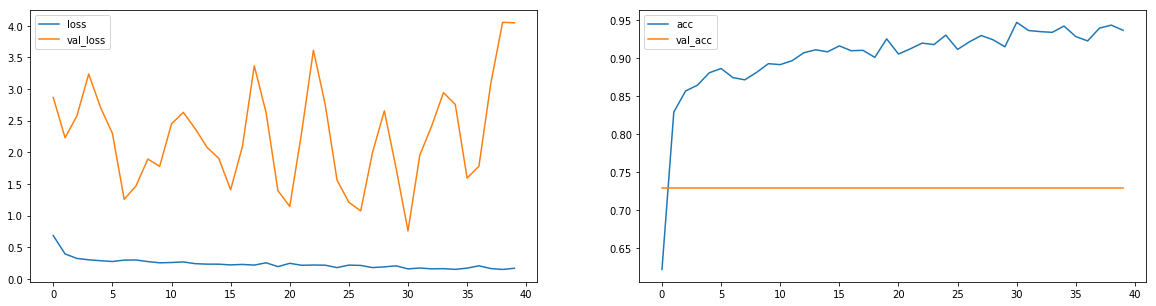


Epoch 00040: val_loss did not improve


In [13]:
checkpointer = ModelCheckpoint(filepath='Test6-TransferLearning-InceptionV3.weights.best.hdf5', verbose=1, save_best_only=True)
plot_losses = PlotLosses(plot_interval=plot_interval, evaluate_interval=None, x_val=x_test, y_val_categorical=y_test)

model.fit(x_train, 
          y_train,
          epochs=epochs, 
          batch_size=batch_size, 
          #verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[plot_losses, 
                     checkpointer],
         )

In [14]:
model.load_weights('Test6-TransferLearning-InceptionV3.weights.best.hdf5')
score = model.evaluate(x_val, y_val, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.7553279394440879
accuracy:  0.7300683369940668


[[  0. 237.]
 [  0. 641.]]


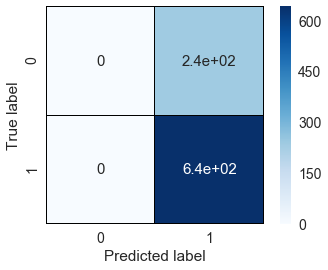

In [15]:
model.load_weights('Test6-TransferLearning-InceptionV3.weights.best.hdf5')
plot_confusion_matrix(model.predict_classes(x_val), y_val)